In [116]:
# modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import chardet
import csv
import os
import matplotlib.dates as mdates
from IPython.display import Image

### Inserez les chemins vers le fichiers CSV:

In [117]:
# on récupère les informations du dossier
dossier = './raw_data'
contenuDossier = os.listdir(dossier)
print(contenuDossier)
nombrePoints = 0
nomPoints = []
numeroPoints = []
# on parcours le dossier en recherchant les fichiers des points
for x in contenuDossier:
    if x.startswith('point'):
        nombrePoints += 1
        nomPoints.append(x)
        numeroPoints.append(x[5:7])
print(numeroPoints)

['point14_29_07_15', 'point15_29_07_15', '.DS_Store', 'schema_dispositif_AvAv_23_07_15.png', 'Point034', 'point13_29_07_15']
['14', '15', '13']


In [118]:
def read_csv (chemin_fichier):
    #Detecter separateur
    with open(chemin_fichier, 'r') as file:
        sniffer = csv.Sniffer()
        sample_data = file.read(1024)
        detecter_separateur = (sniffer.sniff(sample_data).delimiter)

    if "Titre" in open(chemin_fichier).readline():
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur, skiprows=1)
    else:
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur)

    return data_frame 

In [119]:
# on crée un dictionnaire avec toutes les informations pour chaque point et on met les dictionnaires dans une liste
data = []
for x in nomPoints :
    dico = {}
    # le numéro
    dico['numero'] = x[5:7]
    # le nom
    dico['nom'] = x
    # la date
    dico['date'] = x[8:18]
    # le chemin vers le dossier
    dico['chemin'] = dossier + '/' + x
    with open(dico['chemin'] + '/geometrie.txt', 'r') as fichier:
        lignes = fichier.readlines()
        # le nom du capteur
        dico['capteur'] = lignes[1][:4]
        # la profondeur du capteur
        if lignes[3] == '\n' :
            dico['profondeur'] = 0
        else : 
            dico['profondeur'] = lignes[3]
        # les profondeurs auquelles on fait les mesures
        dico['profondeurMesures'] = []
        profMes = lignes[5].split(';')
        for num in profMes :
            dico['profondeurMesures'].append(int(num))
    # on va ensuite mettre les dataframes dans le dictionnaire
    contenuDossierPoint = os.listdir(dico['chemin'])
    for x in contenuDossierPoint:
        # la pression
        if x.startswith('p') and x.endswith('.csv'):
            dico['pression'] = read_csv(dico['chemin'] + '/' + x)
        # la température
        if x.startswith('t') and x.endswith('.csv'):
            dico['temperature'] = read_csv(dico['chemin'] + '/' + x)
    # dans les configurations du capteur on va chercher les données
    with open('configuration/pressure_sensors/P' + dico['capteur'][1:] +'.csv' ) as fichier :
        lignes = fichier.readlines()
        for l in lignes :
            if l.startswith('Intercept') :
                dico['intercept'] = float(l[10:-2])
            if l.startswith('dU/dH') :
                dico['dU/dH'] = float(l[6:-2])
            if l.startswith('dU/dT') :
                dico['dU/dT'] = float(l[6:-2]) 
    data.append(dico)


In [120]:
# en faisant data[0] on a accès à toutes les informations du point 1
data[0]

{'numero': '14',
 'nom': 'point14_29_07_15',
 'date': '29_07_15',
 'chemin': './raw_data/point14_29_07_15',
 'capteur': 'p507',
 'profondeur': 0,
 'profondeurMesures': [10, 20, 30, 40],
 'pression':        #  Date Heure GMT+02:00  \
 0      1  07/23/15 02:00:00 PM   
 1      2  07/23/15 02:15:00 PM   
 2      3  07/23/15 02:30:00 PM   
 3      4  07/23/15 02:45:00 PM   
 4      5  07/23/15 03:00:00 PM   
 ..   ...                   ...   
 558  559  07/29/15 09:30:00 AM   
 559  560  07/29/15 09:45:00 AM   
 560  561  07/29/15 10:00:00 AM   
 561  562  07/29/15 10:15:00 AM   
 562  563  07/29/15 10:30:00 AM   
 
      Tension V (LGR S/N: 10614065 SEN S/N: 10614065)  \
 0                                            0.01183   
 1                                            0.00080   
 2                                            0.00080   
 3                                            0.00092   
 4                                            0.00088   
 ..                                   

# Est ce que les fichiers peuvent être utilisés ?

**Dans notre cas, nous prendrons ces solutions**

* S'il manque toutes les données du capteurs de pression ou l'étalonnage, nous déciderons que ce point est invalide.
* S'il manque une partie des données nous vérifierons que nous avons au mimimun 7 jours de données
* S'il manque plus de 2 capteurs de température, nous déciderons que ce point est invalide.

### Est ce que nous avons les données de l'étalonnage du capteur ?

In [121]:
for x in data :
    if not 'intercept' in x.keys() :
        print('le point '+ x['numero'] + ' n\'a pas d\'étalonnage, il n\'est pas valide')
        data.remove(x)

### Est ce que nous avons des données pour le capteur de pression ?

In [122]:
for x in data :
    if x['pression'].empty :
        print('le point '+ x['numero'] + ' n\'a pas de données de pression, il n\'est pas valide')
        data.remove(x)

### On modifie les nom des colonnes du dataframe

In [123]:
# pour les températures
for x in data :
    # on supprime la première colonne si elle ne sert à rien
    for i in x['temperature'].columns :
        if not( i.startswith('Date') or i.startswith('Temp')) :
            del x['temperature'][i]
    for i in x['pression'].columns :
        if not( i.startswith('Date') or i.startswith('Tension') or i.startswith('Temp')) :
            del x['pression'][i]
    # on renomme les colonnes
    profondeur = x['profondeurMesures']
    colonnesT = ['dates']
    for num in profondeur :
        colonnesT.append('Temp_profondeur_'+ str(num))
    x['temperature'].columns = colonnesT
    colonnesP = ['dates', 'tension', 'temperature_stream']
    x['pression'].columns = colonnesP

In [124]:
# notamment la température et la pression
data[0]['temperature'].head(5)

,dates,Temp_profondeur_10,Temp_profondeur_20,Temp_profondeur_30,Temp_profondeur_40
0,07/23/15 02:00:00 PM,26.207,27.554,26.378,28.097
1,07/23/15 02:15:00 PM,28.147,27.087,26.867,29.265
2,07/23/15 02:30:00 PM,28.419,28.543,27.431,29.615
3,07/23/15 02:45:00 PM,18.390,21.223,18.319,19.555
4,07/23/15 03:00:00 PM,18.509,21.318,18.461,19.413


### Conversion de valeurs de tension a differance de charge

In [125]:
for point in data:
    k0 = float(point['intercept'])
    k1 = float(point['dU/dH'])
    k2 = float(point['dU/dT'])
    
    # Calcul de la colonne 'dH' en utilisant la formule H = 1/k1 * (U - k0 - k2 * T)
    U = point['pression']['tension'].astype(float)
    T = point['pression']['temperature_stream'].astype(float)
    point['pression']['dH'] = (1 / k1) * (U - k0 - k2 * T)

data[0]['pression']

,dates,tension,temperature_stream,dH
0,07/23/15 02:00:00 PM,0.01183,45.230,0.183945
1,07/23/15 02:15:00 PM,0.00080,21.979,0.104472
2,07/23/15 02:30:00 PM,0.00080,21.609,0.103194
3,07/23/15 02:45:00 PM,0.00092,21.910,0.104225
4,07/23/15 03:00:00 PM,0.00088,20.966,0.100966
...,...,...,...,...
558,07/29/15 09:30:00 AM,1.23991,15.562,-0.014592
559,07/29/15 09:45:00 AM,1.23709,15.541,-0.014444
560,07/29/15 10:00:00 AM,1.24273,15.513,-0.014982
561,07/29/15 10:15:00 AM,1.24022,15.599,-0.014488


### On supprime les valeurs NaN

In [126]:
for x in data :
    x['temperature'] = x['temperature'].dropna(axis = 0, how = 'any')
    x['pression'] = x['pression'].dropna(axis = 0, how='any')

## Conversion de format des dates

In [127]:
# Conversion dans le bon format date
for point in data:
    point['pression']['dates'] = pd.to_datetime(point['pression']['dates'], format='%m/%d/%y %I:%M:%S %p')
    point['temperature']['dates'] = pd.to_datetime(point['temperature']['dates'], format='%m/%d/%y %I:%M:%S %p')

### On supprime les valeurs aberrants

In [128]:
from scipy import stats

for x in data :
    # Traiter chaque colonne sauf la colonne des dates
    columns_to_processP = [col for col in x['pression'].columns if col != 'dates']
    columns_to_processT = [col for col in x['temperature'].columns if col != 'dates']
    # Créer un DataFrame vide pour stocker les données traitées
    x['pression2'] = x['pression'][['dates']].copy()
    x['temperature2'] = x['temperature'][['dates']].copy()
    # Boucler à travers chaque colonne à traiter
    for column_name in columns_to_processP :
        # Calculer le Z-score pour la colonne
        z_scores = np.abs(stats.zscore(x['pression'][column_name]))
        # Définir un seuil pour le Z-score (par exemple, 3)
        threshold = 3 #doit demander au client pour chaque point
        # Sélectionner les lignes avec des Z-scores inférieurs au seuil
        df_cleaned = x['pression'][z_scores < threshold] 
        # Copier les données traitées dans df_processed
        x['pression2'][column_name] = df_cleaned[column_name]
    # pareil pour les températures
    for column_name in columns_to_processT :
        # Calculer le Z-score pour la colonne
        z_scores = np.abs(stats.zscore(x['temperature'][column_name]))
        # Définir un seuil pour le Z-score (par exemple, 3)
        threshold = 3
        # Sélectionner les lignes avec des Z-scores inférieurs au seuil
        df_cleaned = x['temperature'][z_scores < threshold] 
        # Copier les données traitées dans df_processed
        x['temperature2'][column_name] = df_cleaned[column_name]

In [129]:
for x in data :
    x['temperature2'] = x['temperature2'].dropna(axis = 0, how = 'any')
    x['pression2'] = x['pression2'].dropna(axis = 0, how='any')

### Est ce que nous avons au minimum 4 jours de données ?

In [130]:
# on met à jour la date de début de la mesure, la date de fin et la période
for x in data :
    x['dateDebut'] = x['pression2']['dates'].iloc[0]
    x['dateFin'] = x['pression2']['dates'].iloc[x['pression2']['dates'].shape[0]-1]
    x['periode'] = x['dateFin'] - x['dateDebut']

In [131]:
for x in data :
    if int(str(x['periode'])[0]) <= 4 :
        print('le point ' + x['numero'] + ' n\'est pas valide car sa période est de seulement ' + str(x['periode'])[0] +' jours')
        #data.remove(x)

le point 15 n'est pas valide car sa période est de seulement 0 jours


### Création du fichier `info.txt`

In [132]:
# Ouvrez un fichier en mode écriture ('w')
for x in data :
    if os.path.exists(x['chemin'] + '/point' + x['numero'] + '_info.txt') :
        os.remove(x['chemin'] + '/point' + x['numero'] + '_info.txt')
    with open(x['chemin'] + '/point' + x['numero'] + '_info.txt', 'w') as fichier:
        # Parcourez le dictionnaire et écrivez les données dans le fichier
        fichier.write('Point_Name,Point' + x['numero'] + '\n')
        fichier.write('P_Sensor_Name,' + x['capteur'] + '\n')
        fichier.write('Implantation_Date,' + x['date'] + '\n')
        fichier.write('Meas_date,' + str(x['dateDebut']) + '\n')
        fichier.write('River_Deb,' '\n') 
        fichier.write('Delta_h,' + '\n')
        fichier.write('Periode,' + str(x['periode']) + '\n')

# Traitement du signal de temperature

On a choisi un seul point (point 13) pour faire le traitement du signal et conclure qu'il y a pas de rapport entre la temperature de la rivière et la difference de charge

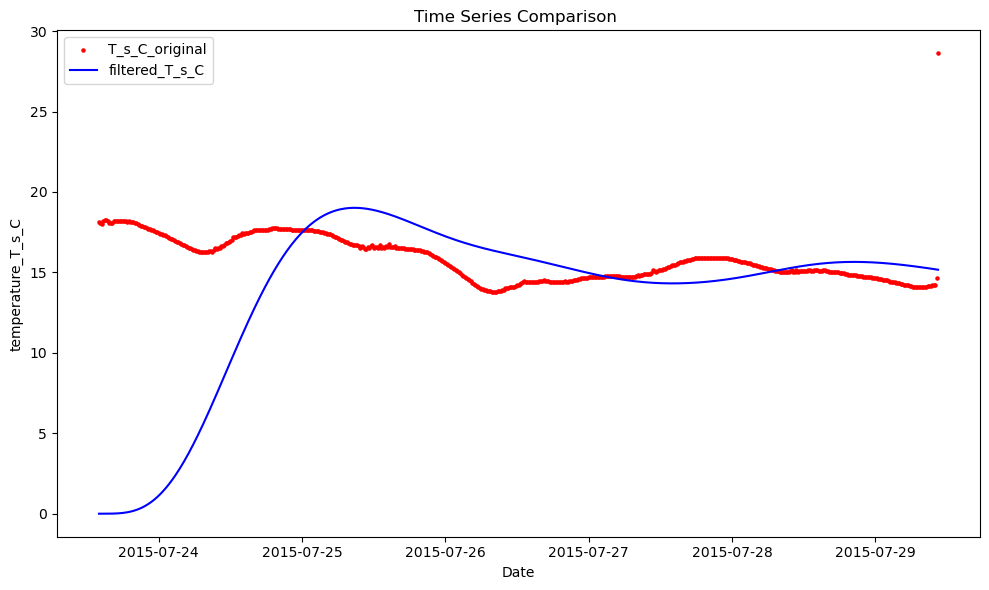

In [133]:
from scipy import signal

# Butterworth filter method

T_s_C = data[2]['pression'][['temperature_stream','dates']]

data_to_filter = T_s_C['temperature_stream']

order = 4
cutoff_freq = 2*(15/60/48)
b, a = signal.butter(order, cutoff_freq, 'lowpass')
filtered_T = signal.lfilter(b, a, data_to_filter)

filtered_T_s_C = pd.DataFrame({'filtered_temperature_stream': filtered_T, 'dates': T_s_C['dates']})


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(T_s_C["dates"], T_s_C["temperature_stream"], color="red", label="T_s_C_original", s=5)
ax.plot(filtered_T_s_C["dates"], filtered_T_s_C["filtered_temperature_stream"], color="blue", label="filtered_T_s_C")
ax.set_xlabel("Date")
ax.set_ylabel("temperature_T_s_C")
ax.set_title("Time Series Comparison ")
ax.legend()

plt.tight_layout()
plt.show()


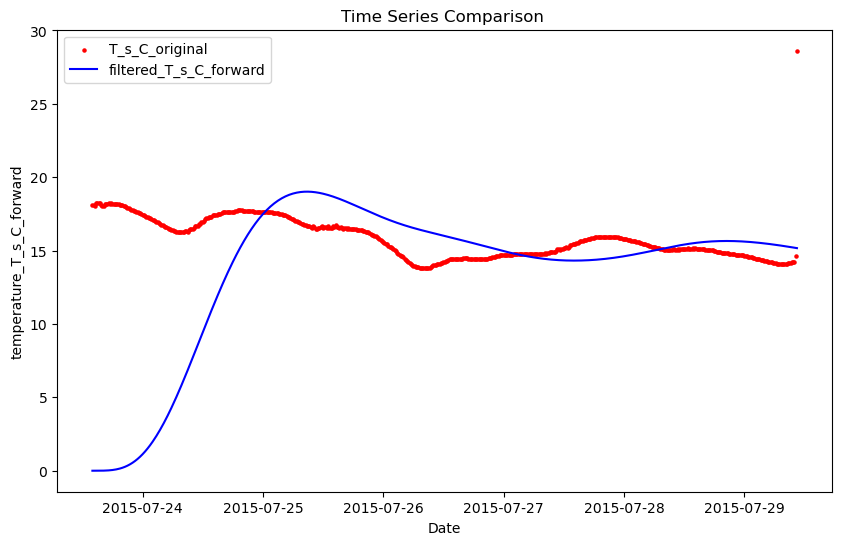

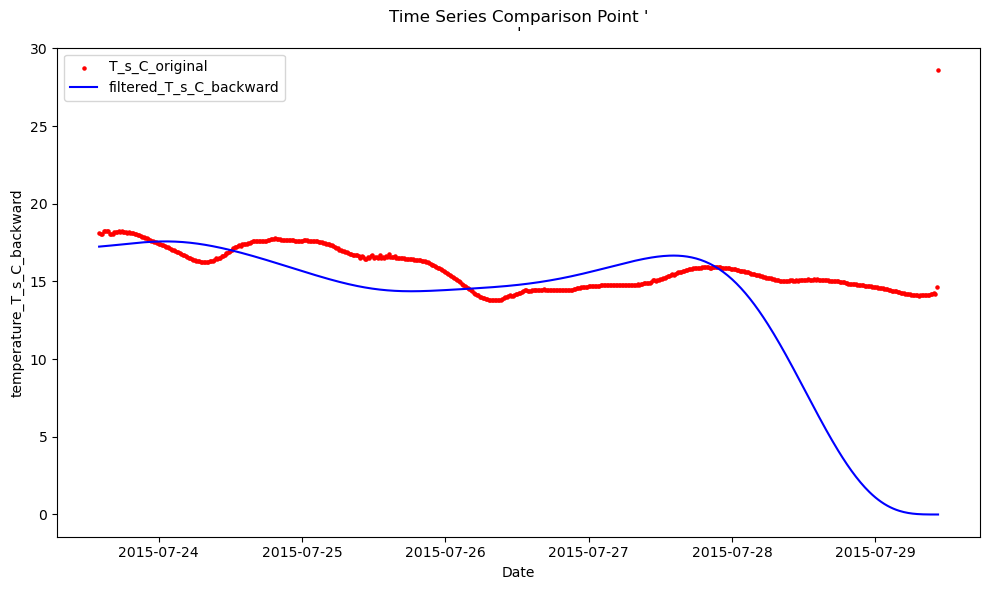

In [134]:
# Butterworth two-way-filter method

forward_filtered_signal = signal.lfilter(b, a, data_to_filter)

reversed_signal = data_to_filter[::-1]
backward_filtered_signal = signal.lfilter(b, a, reversed_signal)
backward_filtered_signal = backward_filtered_signal[::-1]

filtered_T_s_C_forward = pd.DataFrame({'filtered_temperature_stream': forward_filtered_signal, 'dates': T_s_C['dates']})
filtered_T_s_C_backward = pd.DataFrame({'filtered_temperature_stream': backward_filtered_signal, 'dates': T_s_C['dates']})

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(T_s_C["dates"], T_s_C["temperature_stream"], color="red", label="T_s_C_original", s=5)
ax.plot(filtered_T_s_C_forward["dates"], filtered_T_s_C_forward["filtered_temperature_stream"], color="blue", label="filtered_T_s_C_forward")
ax.set_xlabel("Date")
ax.set_ylabel("temperature_T_s_C_forward")
ax.set_title("Time Series Comparison " )
ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(T_s_C["dates"], T_s_C["temperature_stream"], color="red", label="T_s_C_original", s=5)
ax.plot(filtered_T_s_C_backward["dates"], filtered_T_s_C_backward["filtered_temperature_stream"], color="blue", label="filtered_T_s_C_backward")
ax.set_xlabel("Date")
ax.set_ylabel("temperature_T_s_C_backward")
ax.set_title("Time Series Comparison Point '\n'")
ax.legend()

plt.tight_layout()
plt.show()

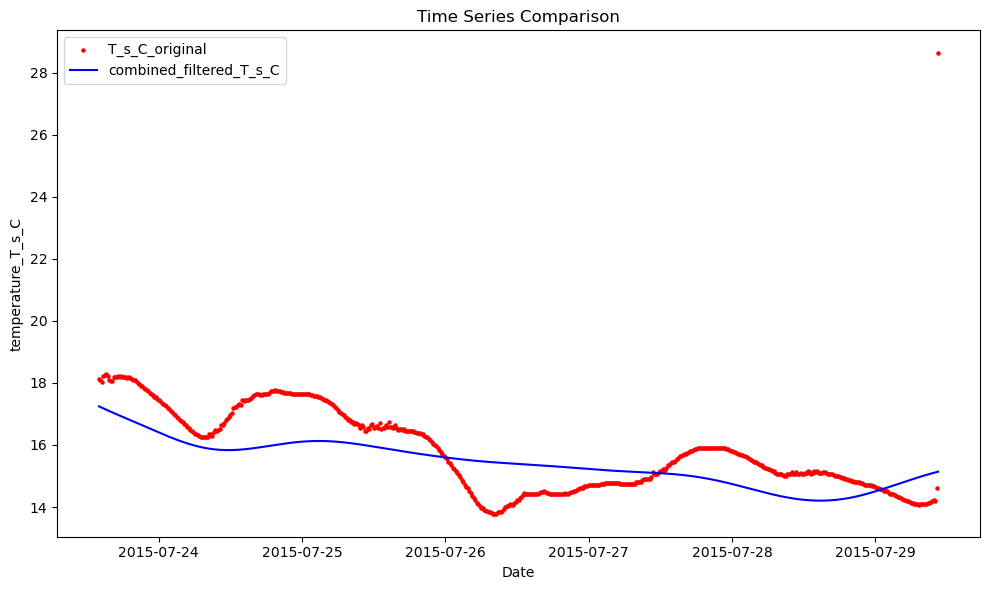

In [135]:
# Combination of two-way-filtered signal with weight fonction

L = len(data_to_filter)
weight = np.zeros(L)
combined_filtered_signal = np.zeros(L)

a = 1.0 / L
for i in range(L):
    weight[i] = i * a

for i in range(L):
    combined_filtered_signal[i] = forward_filtered_signal[i] * weight[i] + backward_filtered_signal[i] * (1-weight[i])

combined_filtered_T_s_C = pd.DataFrame({'combined_filtered_temperature_stream': combined_filtered_signal, 'dates': T_s_C['dates']})
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(T_s_C["dates"], T_s_C["temperature_stream"], color="red", label="T_s_C_original", s=5)
ax.plot(combined_filtered_T_s_C["dates"], combined_filtered_T_s_C["combined_filtered_temperature_stream"], color="blue", label="combined_filtered_T_s_C")
ax.set_xlabel("Date")
ax.set_ylabel("temperature_T_s_C")
ax.set_title("Time Series Comparison")
ax.legend()

plt.tight_layout()
plt.show()

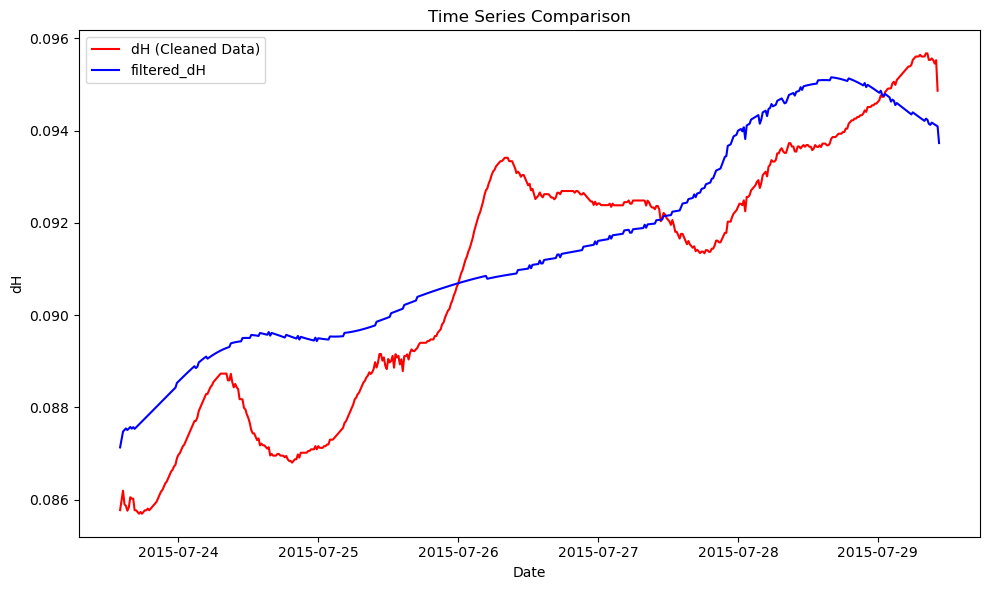

In [136]:
# Regenerate dH with the filtered temperature
filtered_dH = pd.DataFrame()

k0 = float(data[2]['intercept'])
k1 = float(data[2]['dU/dH'])
k2 = float(data[2]['dU/dT'])

U = data[2]['pression']['tension'].astype(float)
T = combined_filtered_T_s_C["combined_filtered_temperature_stream"].astype(float)
#point['pression']['dH'] = (1 / k1) * (U - k0 - k2 * T)

# filtered_dH['filtered_dH'] = (1 / k1) * (capteur_riviere['tension_V'].astype(float) - k0 ）
filtered_dH['filtered_dH'] = (1 / k1) * (U - k0 - k2 * T)
filtered_dH['dates'] = T_s_C['dates']

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(data[2]['pression2']["dates"], data[2]['pression2']["dH"], color="red", label="dH (Cleaned Data)")
ax.plot(filtered_dH["dates"], filtered_dH["filtered_dH"], color="blue", label="filtered_dH")
ax.set_xlabel("Date")
ax.set_ylabel("dH")
ax.set_title("Time Series Comparison")
ax.legend()

plt.tight_layout()
plt.show()

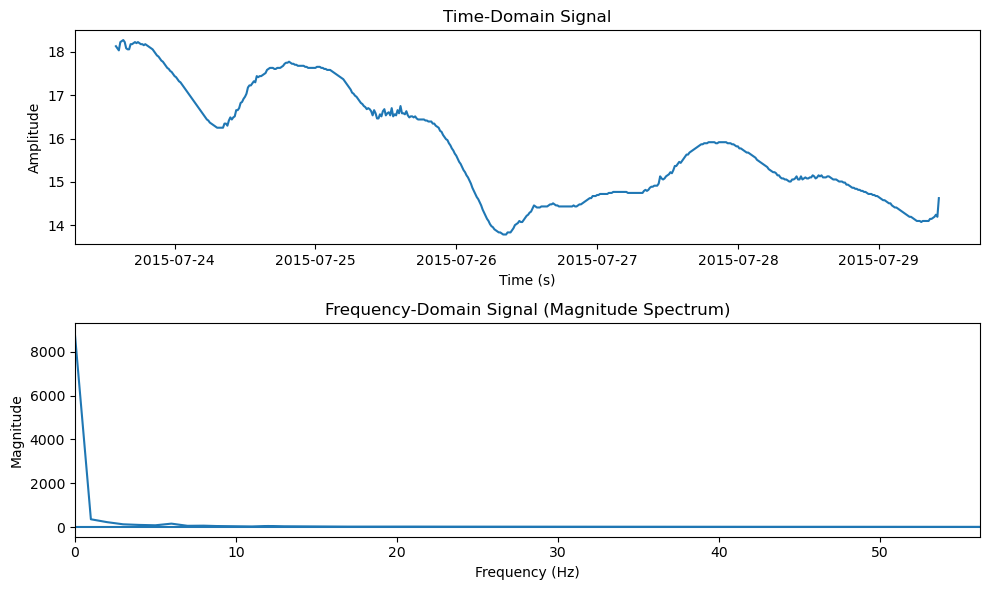

In [137]:
import numpy as np
import matplotlib.pyplot as plt

# Sample rate (Hz) and duration (second)
sample_rate = len(data[2]['pression2']['temperature_stream'])  # Adjust as needed
#duration = 1  # Adjust as needed
#t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
t = data[2]['pression2']['dates']

# Perform the Fourier transform
fft_result = np.fft.fft(data[2]['pression2']['temperature_stream'])
fft_freq = np.fft.fftfreq(len(t), 1 / sample_rate)

# Calculate the magnitude of the spectrum
magnitude = np.abs(fft_result)

# Plot the time-domain and frequency-domain signals
plt.figure(figsize=(10, 6))

# Time-domain signal
plt.subplot(2, 1, 1)
plt.plot(t, data[2]['pression2']['temperature_stream'])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time-Domain Signal')

# Frequency-domain signal (Magnitude Spectrum)
plt.subplot(2, 1, 2)
plt.plot(fft_freq, magnitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency-Domain Signal (Magnitude Spectrum)')
plt.xlim(0, sample_rate / 10)  # Display the positive frequency range

plt.tight_layout()
plt.show()



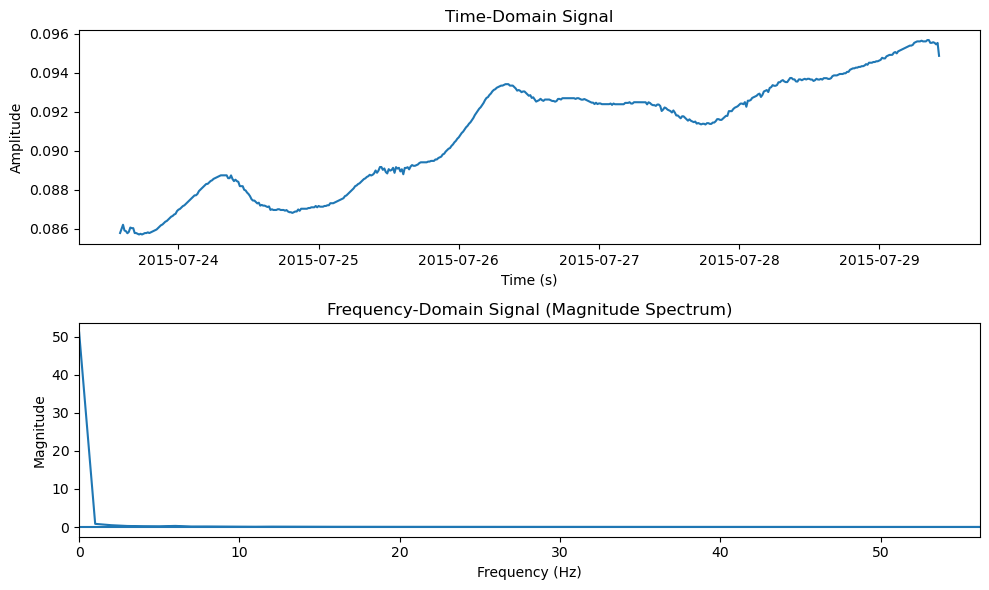

In [138]:

# Sample rate (Hz) and duration (second)
sample_rate = len(data[2]['pression2']['dH'])  # Adjust as needed
#duration = 1  # Adjust as needed
#t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
t = data[2]['pression2']['dates']

# Perform the Fourier transform
fft_result = np.fft.fft(data[2]['pression2']['dH'])
fft_freq = np.fft.fftfreq(len(t), 1 / sample_rate)

# Calculate the magnitude of the spectrum
magnitude = np.abs(fft_result)

# Plot the time-domain and frequency-domain signals
plt.figure(figsize=(10, 6))

# Time-domain signal
plt.subplot(2, 1, 1)
plt.plot(t, data[2]['pression2']['dH'])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time-Domain Signal')

# Frequency-domain signal (Magnitude Spectrum)
plt.subplot(2, 1, 2)
plt.plot(fft_freq, magnitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency-Domain Signal (Magnitude Spectrum)')
plt.xlim(0, sample_rate / 10)  # Display the positive frequency range

plt.tight_layout()
plt.show()

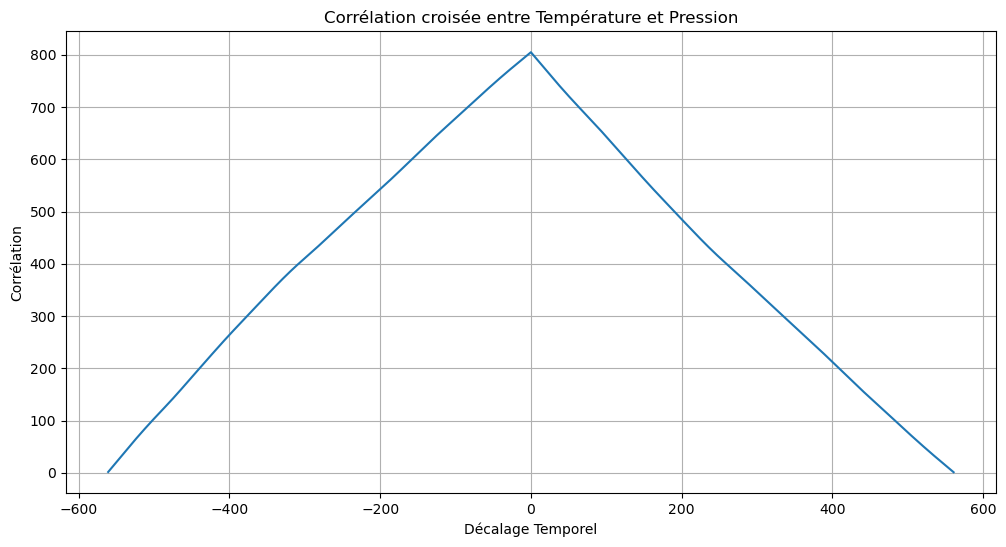

In [139]:
# Exemple de signaux de température et de pression (remplacez-les par vos données réelles)
temperature = data[2]['pression2']['temperature_stream']
pression = data[2]['pression2']['dH']

# Calculez la corrélation croisée entre les deux signaux
cross_correlation = np.correlate(temperature, pression, mode='full')

# Calculez les décalages temporels correspondant à la corrélation croisée
time_lags = np.arange(-len(temperature) + 1, len(temperature))

# Affichez la corrélation croisée
plt.figure(figsize=(12, 6))
plt.plot(time_lags, cross_correlation)
plt.title('Corrélation croisée entre Température et Pression')
plt.xlabel('Décalage Temporel')
plt.ylabel('Corrélation')
plt.grid(True)
plt.show()


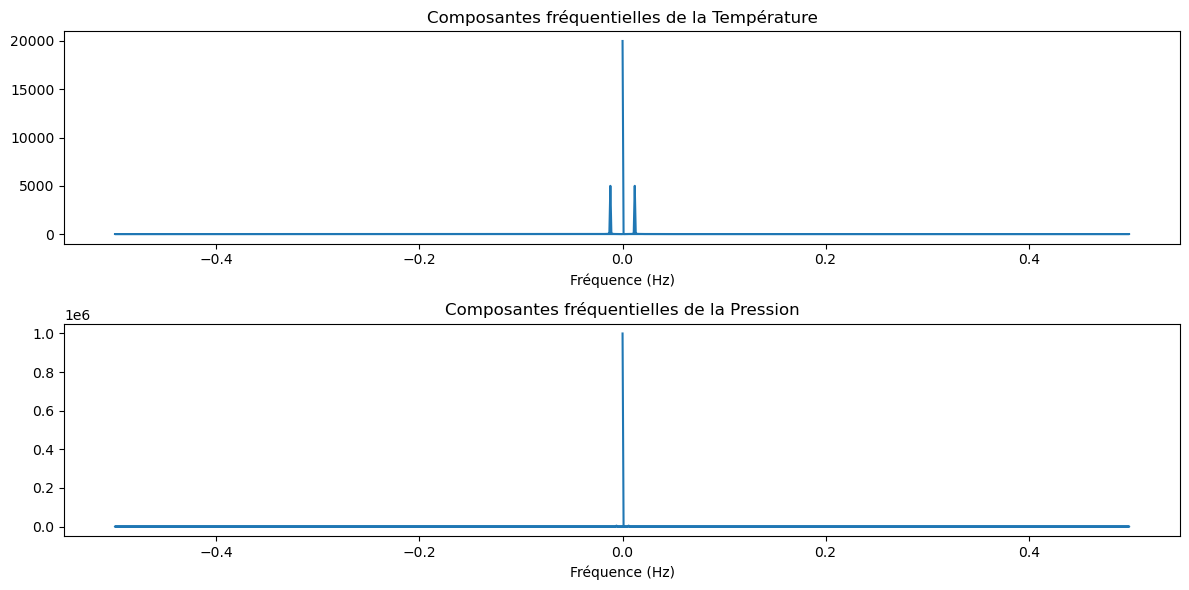

In [140]:
import numpy as np
import matplotlib.pyplot as plt

# Exemple de signaux de température et de pression (remplacez-les par vos données réelles)
time = np.linspace(0, 24, 1000)  # Temps en heures
temperature = 10 * np.sin(2 * np.pi * 0.5 * time) + 20  # Signal de température
pression = 1000 + 10 * np.sin(2 * np.pi * 0.25 * time)  # Signal de pression

# Calcul de la transformée de Fourier
fft_temperature = np.fft.fft(temperature)
fft_pression = np.fft.fft(pression)
freq = np.fft.fftfreq(len(time))

# Affichage des composantes fréquentielles
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(freq, np.abs(fft_temperature))
plt.title('Composantes fréquentielles de la Température')
plt.xlabel('Fréquence (Hz)')
plt.subplot(2, 1, 2)
plt.plot(freq, np.abs(fft_pression))
plt.title('Composantes fréquentielles de la Pression')
plt.xlabel('Fréquence (Hz)')
plt.tight_layout()
plt.show()
